In [1]:
!pip install -q git+git://github.com/deepmind/optax.git
!pip install -q git+https://github.com/deepmind/dm-haiku

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.3.1 requires numpy<1.19.0,>=1.16.0, but you have numpy 1.19.4 which is incompatible.
tensorflow-gpu 2.3.1 requires numpy<1.19.0,>=1.16.0, but you have numpy 1.19.4 which is incompatible.
nibabel 2.5.2 requires numpy<1.17dev,>=1.8, but you have numpy 1.19.4 which is incompatible.
You should consider upgrading via the '/home/sean/wd/pgm-fmri/venv/bin/python3.6 -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/sean/wd/pgm-fmri/venv/bin/python3.6 -m pip install --upgrade pip' command.


In [2]:
from typing import Any, Generator, Mapping, Tuple

from absl import app
import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
import optax
import tensorflow as tf
import tensorflow_datasets as tfds
from optax._src import transform
from jax import jit, grad, vmap
from jax.tree_util import tree_structure
from numpy.random import default_rng

import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, utils


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

np.set_printoptions(precision=2,suppress=True)
np.random.seed(0)


In [27]:
# for every environment, pick at random a strongest predictor (does not have to be unique) + random small coefficients for all others
# EXCEPT for a subset of predictors which are consistent across all environments

def generate_synthetic_dataset(E,ntrain,glob_sigma,sig_sigma,K,rand_strong_coefs,inv_weak_coefs,true_pred_indices,n_informative,n_redundant,use_sklearn,ilc_sr):
    # more info for sklearn dataset generation: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html#sklearn.datasets.make_classification
    dist = torch.distributions.Uniform(-1, 1)
    if use_sklearn:
      X,y = make_classification(n_samples=E, 
                          n_features=K, 
                          n_informative=n_informative,
                          n_redundant=n_redundant, 
                          n_repeated=0, 
                          n_classes=2, 
                          n_clusters_per_class=2, 
                          weights=None, 
                          flip_y=sig_sigma, 
                          class_sep=glob_sigma, 
                          hypercube=True, 
                          shift=0.0, 
                          scale=1.0, 
                          shuffle=False, 
                          random_state=np.random.seed(0))
    else:
      rng = default_rng()
      #np.random.seed(100)
      X = np.random.normal(0, glob_sigma, (E, K))
      #y = np.random.randint(2,size=E)
      y = rng.choice(2, size=E, replace=True)

      for e in range(E):
        # new seed
        #np.random.seed(e)
        # pick a subset of best predictors at random 
        #rand_best_indices = np.random.randint(K, size=3)
        rand_best_indices = rng.choice(K, size=1, replace=False)

        # check to make sure these randoms aren't out true pred
        condition = True
        while condition:
          for i,rbp in enumerate(rand_best_indices):
            if rbp in true_pred_indices:
              #rand_best_indices[i] = np.random.randint(K, size=1)
              rand_best_indices[i] = rng.choice(K, size=1, replace=False)
              condition = True
              break
            else:
              condition = False
        #print(true_pred_indices,rand_best_indices)
        # set the coefficients at the right row 
        # that separates each class
        if y[e] == 1:
          X[e,true_pred_indices] = inv_weak_coefs # +  np.random.normal(0,sig_sigma)
          X[e,rand_best_indices] = rand_strong_coefs + np.random.normal(0,sig_sigma)# + dist.sample(X[e,rand_best_indices].shape)  #

        elif y[e] == 0:
          X[e,true_pred_indices] = 0 #+  np.random.normal(0,sig_sigma) #-inv_weak_coefs 
          X[e,rand_best_indices] = 0 +np.random.normal(0,sig_sigma) # dist.sample(X[e,rand_best_indices].shape)


    #Z = np.c_[ X, y ]   
    #print(np.corrcoef(Z.T))
    print(X,y)
    return y,X



In [4]:
class ANDMaskState(optax.OptState):
  """Stateless.""" # Following optax code style

def and_mask(agreement_threshold: float) -> optax.GradientTransformation:
  def init_fn(_):
    # Required by optax
    return ANDMaskState()

  def update_fn(updates, opt_state, params=None):

    def and_mask(update):
      # Compute the masked gradients for a single parameter tensor
      mask = jnp.abs(jnp.mean(jnp.sign(update), 0)) >= agreement_threshold
      mask = mask.astype(jnp.float32)
      avg_update = jnp.mean(update, 0)
      mask_t = mask.sum() / mask.size
      update = mask * avg_update * (1. / (1e-10 + mask_t))
      return update

    del params # Following optax code style
    
    # Compute the masked gradients over all parameters

    # jax.tree_map maps a function (lambda function in this case) over a pytree to produce a new pytree.
    updates = jax.tree_map(lambda x: and_mask(x), updates)
    return updates, opt_state

  return transform.GradientTransformation(init_fn, update_fn)

In [118]:
def sparse_logistic_regression_synthetic_data(train, test, adam_lr=1e-3, agreement_threshold=0.0,
                               use_ilc=False, l1_coef=1e-4, l2_coef=1e-4,
                               epochs=10001, Verbose=False, training=True, n_classes=2, normalizer=255.,ilc_start_epoch=0.5):

  
    OptState = Any
    Batch = Mapping[str, np.ndarray]

    def evaluate(params, validation_data, validation_labels):
    
        logits = net.apply(params, validation_data)
        preds = jax.nn.log_softmax(logits)
        pred_labels = np.argmax(preds, axis=1)

        acc = accuracy(params, validation_data, validation_labels)
        # As mentioned before, data is unbalanced, hence, the accuracy itself is not 
        # enough for evaluating the performance of the model.
        # print(outputs,local_labels.cpu().detach().numpy())
        cm = confusion_matrix(pred_labels.transpose(), validation_labels.transpose())
        #sns.set_theme()
        #plt.figure()
        #ax = sns.heatmap(cm)
        print('\nConfusion Matrix: ', cm)
        precision,recall,fscore,_ = precision_recall_fscore_support(validation_labels, pred_labels)
        print('\nAccuracy: ', acc,'\nPrecision: ',precision,'\nRecall: ', recall,'\nF-score: ', fscore)


    training_accs = []
    testing_accs = []

    def net_fn(batch) -> jnp.ndarray:
    
        x = jnp.array(batch, jnp.float32) / normalizer
        mlp = hk.Sequential([
            hk.Flatten(),
            hk.Linear(n_classes),
        ])
        return mlp(x)


    # Make the network and optimiser.
    net = hk.without_apply_rng(hk.transform(net_fn))

    
       
    # Training loss (cross-entropy).
    def loss(params: hk.Params, batch, label) -> jnp.ndarray:
        """Compute the loss of the network, including L2."""
        logits = net.apply(params, batch)
        labels = jax.nn.one_hot(label, n_classes)

        # Cross Entropy Loss
        softmax_xent = -jnp.sum(labels * jax.nn.log_softmax(logits))
        softmax_xent /= labels.shape[0]
        return softmax_xent
        
    # Regularization loss (L1,L2).
    def regularization_loss(params: hk.Params) -> jnp.ndarray:
        """Compute the regularization loss of the network, applied after ILC."""

        # L1 Loss
        sum_in_layer = lambda p: jnp.sum(jnp.abs(p))
        sum_p_layers = [sum_in_layer(p) for p in jax.tree_leaves(params)]
        l1_loss = sum(sum_p_layers)

        # L2 Loss
        l2_loss = 0.5 * sum(jnp.sum(jnp.square(p)) for p in jax.tree_leaves(params))

        return l2_coef * l2_loss + l1_coef * l1_loss


    @jax.jit
    def gradient_per_sample(params, batch, label):
        batch, label = jnp.expand_dims(batch,1), jnp.expand_dims(label,1)
        return vmap(grad(loss), in_axes=(None, 0, 0))(params, batch, label)

    
    gradient = jax.jit(grad(loss))
    gradient_reg = jax.jit(grad(regularization_loss))

    # Evaluation metric (classification accuracy).
    @jax.jit
    def accuracy(params: hk.Params, batch, label) -> jnp.ndarray:
        predictions = net.apply(params, batch)
        return jnp.mean(jnp.argmax(predictions, axis=-1) == label)


    
    @jax.jit
    def update(
        params: hk.Params,
        opt_state: OptState,
        batch, label, agreement
        ) -> Tuple[hk.Params, OptState]:
        """Learning rule (stochastic gradient descent)."""
        # grads = jax.grad(loss)(params, batch, label)
        # grads_masked = (gradient_per_sample if use_ilc else gradient)(params, batch, label) # (gradient_per_sample)(params, batch, label)
        # sum_grad_masked_regularized = jax.tree_multimap(lambda x,y:x+y,grads_masked,gradient_reg(params))
        # grads = sum_grad_masked_regularized
        # updates, opt_state = opt.update(grads, opt_state)
        # new_params = optax.apply_updates(params, updates)

        grads_samples = gradient_per_sample(params, batch, label)
        ANDmask = and_mask(agreement)

        masked_grads,_ = ANDmask.update(grads_samples, opt_state)
        reg_grads = gradient_reg(params)

        sum_grad_masked_regularized = jax.tree_multimap(lambda x,y:x+y,masked_grads,reg_grads)
 
        updates,_ = opt.update(sum_grad_masked_regularized, opt_state)

        new_params = optax.apply_updates(params, updates)

        return new_params, opt_state

    # We maintain avg_params, the exponential moving average of the "live" params.
    # avg_params is used only for evaluation.
    # For more, see: https://doi.org/10.1137/0330046
    @jax.jit
    def ema_update(
        avg_params: hk.Params,
        new_params: hk.Params,
        epsilon: float = 0.001,
    ) -> hk.Params:
        return jax.tree_multimap(lambda p1, p2: (1 - epsilon) * p1 + epsilon * p2,
                                avg_params, new_params)

    if training is False:
        return net, accuracy
    else:
        if(use_ilc):

            use_ilc = False

            # opt = optax.chain(and_mask(agreement_threshold) if use_ilc else optax.identity(),optax.adam(adam_lr))

            # schedule_fn = optax.exponential_decay(adam_lr, # Note the minus sign!
            # 1,
            # 0.9)
            # opt = optax.chain(optax.sgd(adam_lr), optax.scale_by_schedule(schedule_fn)) # Or Adam could be used
            opt = optax.chain(optax.sgd(adam_lr)) # Or Adam could be used

            # Initialize network and optimiser; note we draw an input to get shapes.
            params = avg_params = net.init(jax.random.PRNGKey(42), next(train)[0])
            opt_state = opt.init(params)

            # Train/eval loop. WITHOUT ILC
            print("Begin training with ILC")
            for step in range(np.int(ilc_start_epoch*epochs)):
                if step % np.int(epochs/10) == 0:
                    # Periodically evaluate classification accuracy on train & test sets.
                    Batch = next(train)
                    train_accuracy = accuracy(avg_params, Batch[0], Batch[1])
                    train_accuracy = jax.device_get(train_accuracy)
                    Batch = next(test)
                    test_accuracy = accuracy(avg_params, Batch[0], Batch[1])
                    test_accuracy = jax.device_get(test_accuracy)
                    training_accs.append(train_accuracy)
                    testing_accs.append(test_accuracy)
                    if Verbose:
                        print(f"[ILC Off, Step {step}] Train accuracy/Test accuracy: "
                                f"{train_accuracy:.3f} / {test_accuracy:.3f}.")

                # Do SGD on a batch of training examples.
                Batch = next(train)
                params, opt_state = update(params, opt_state, Batch[0], Batch[1], 0.)
                avg_params = ema_update(avg_params, params)


            use_ilc = True

            # opt = optax.chain(optax.adam(adam_lr))

            # Initialize network and optimiser; note we draw an input to get shapes.
            opt_state = opt.init(params)
            
            # Train/eval loop. WITH ILC
            for step in range(np.int((1-ilc_start_epoch)*epochs)):
                if step % np.int(epochs/10) == 0:
                    # Periodically evaluate classification accuracy on train & test sets.
                    Batch = next(train)
                    train_accuracy = accuracy(avg_params, Batch[0], Batch[1])
                    train_accuracy = jax.device_get(train_accuracy)
                    Batch = next(test)
                    test_accuracy = accuracy(avg_params, Batch[0], Batch[1])
                    test_accuracy = jax.device_get(test_accuracy)
                    training_accs.append(train_accuracy)
                    testing_accs.append(test_accuracy)
                    if Verbose:
                        print(f"[ILC On, Step {step}] Train accuracy/Test accuracy: "
                                f"{train_accuracy:.3f} / {test_accuracy:.3f}.")

                # Do SGD on a batch of training examples.
                Batch = next(train)
                params, opt_state = update(params, opt_state, Batch[0], Batch[1], agreement_threshold)
                avg_params = ema_update(avg_params, params)

            print("Evaluating with ILC:")
            Batch = next(test)
            test_data, test_labels = Batch[0], Batch[1]
            evaluate(avg_params, test_data, test_labels)


            return params, training_accs, testing_accs

        else:

             # schedule_fn = optax.exponential_decay(adam_lr, # Note the minus sign!
            # 1,
            # 0.9)
            # opt = optax.chain(optax.sgd(adam_lr), optax.scale_by_schedule(schedule_fn)) # Or Adam could be used
            opt = optax.chain(optax.sgd(adam_lr))

            # Initialize network and optimiser; note we draw an input to get shapes.
            params = avg_params = net.init(jax.random.PRNGKey(42), next(train)[0])
            opt_state = opt.init(params)

            use_ilc=False
            # Train/eval loop. 
            print("Begin training without ILC")
            for step in range(np.int(epochs)):
                if step % np.int(epochs/10) == 0:
                    # Periodically evaluate classification accuracy on train & test sets.
                    Batch = next(train)
                    train_accuracy = accuracy(avg_params, Batch[0], Batch[1])
                    train_accuracy = jax.device_get(train_accuracy)
                    Batch = next(test)
                    test_accuracy = accuracy(avg_params, Batch[0], Batch[1])
                    test_accuracy = jax.device_get(test_accuracy)
                    training_accs.append(train_accuracy)
                    testing_accs.append(test_accuracy)
                    if Verbose:
                        print(f"[ADAM, Step {step}] Train accuracy/Test accuracy: "
                                f"{train_accuracy:.3f} / {test_accuracy:.3f}.")
                        
                # Do SGD on a batch of training examples.
                Batch = next(train)
                params, opt_state = update(params, opt_state, Batch[0], Batch[1], 0.)
                avg_params = ema_update(avg_params, params)
            
            print("Evaluating without ILC:")
            Batch = next(test)
            test_data, test_labels = Batch[0], Batch[1]
            evaluate(avg_params, test_data, test_labels)

            
            return params, training_accs, testing_accs


In [120]:
rng = default_rng()
E = 2000 # number of environments
train_batch_size = np.float32(.5*E)
sigma = [1] # amount of noise 
signal_noise = [1]
K = 1000 # number of predictors (at least 40)
n_informative = 1
n_redundant = 0
nepochs = 10000
weights=[0.7,0.3]
rand_strong_coefs = 3.
inv_weak_coefs = 0.3
use_sklearn = False
ilc_start_epoch = 0.05 # fraction of total epochs
# true invariant predictor indices 
#true_pred_indices = np.random.randint(K, size=n_informative)
true_pred_indices = rng.choice(K, size=n_informative, replace=False)
true_pred_indices
agreement = 0.4
l1_sgd = 0.
l2_sgd = 0.
l1_ilc = 1e-4
l2_ilc = 1e-4

In [122]:
from sklearn.datasets import make_classification

results = []
for global_noise in sigma:
    for sig_noise in signal_noise:
        print(f"Global noise: {global_noise}, Signal noise: {sig_noise}")
        y,x = generate_synthetic_dataset(E,train_batch_size,global_noise,sig_noise,K,rand_strong_coefs,inv_weak_coefs,true_pred_indices,n_informative,n_redundant,use_sklearn)
        
        test_batch_size = E-train_batch_size
        # ds = tfds.load("mnist:3.*.*", split=splits[m]).cache().repeat()
        # print(ds)
        all_dataset = tf.data.Dataset.from_tensor_slices((x, y)).repeat()
        train_dataset = all_dataset.take(train_batch_size).repeat()
        test_dataset = all_dataset.skip(train_batch_size).repeat()
        # print(train_dataset)
        # print(test_dataset)
        train_dataset = train_dataset.shuffle(10.0 * train_batch_size, seed=0)
        train_dataset = train_dataset.batch(train_batch_size)
        train_dataset = iter(tfds.as_numpy(train_dataset))

        test_dataset = test_dataset.shuffle(10.0 * test_batch_size, seed=0)
        test_dataset = test_dataset.batch(test_batch_size)
        test_dataset = iter(tfds.as_numpy(test_dataset))
        
        print("***Using Elastic Net***")
        # sgd
        params_sgd, sgd_train_acc, sgd_test_acc = sparse_logistic_regression_synthetic_data(train_dataset, test_dataset, adam_lr=1e-1, agreement_threshold=0.,
                                       use_ilc=False, l1_coef=l1_sgd, l2_coef=l2_sgd,
                                       epochs=nepochs, Verbose=True, training=True, n_classes=2, normalizer=1.,ilc_start_epoch=ilc_start_epoch)
        [results.append({'Epoch':i,'Method': 'SGD', 'Accuracy': sgd_train_acc[i],'Set':'Train'}) for i in range(len(sgd_train_acc))]
        [results.append({'Epoch':i,'Method': 'SGD', 'Accuracy': sgd_test_acc[i],'Set':'Test'}) for i in range(len(sgd_test_acc))]
         #results.append({'Method': 'SGD', 'Accuracy': sgd_test_acc,'Set':'Test'})
        # print(params)
        # sgd-ilc
        params_sgd_ilc, sgd_ilc_train_acc, sgd_ilc_test_acc = sparse_logistic_regression_synthetic_data(train_dataset, test_dataset, adam_lr=1e-1, agreement_threshold=agreement,
                                use_ilc=True, l1_coef=l1_ilc, l2_coef=l2_ilc,
                                epochs=nepochs, Verbose=True, training=True, n_classes=2, normalizer=1.,ilc_start_epoch=ilc_start_epoch)
        #results.append({'Method': 'SGD-ILC', 'Accuracy': sgd_ilc_train_acc,'Set':'Train'})
        [results.append({'Epoch':i,'Method': 'SGD-ILC', 'Accuracy': sgd_ilc_train_acc[i],'Set':'Train'}) for i in range(len(sgd_ilc_train_acc))]
        #results.append({'Method': 'SGD-ILC', 'Accuracy': sgd_ilc_test_acc,'Set':'Test'})
        [results.append({'Epoch':i,'Method': 'SGD-ILC', 'Accuracy': sgd_ilc_test_acc[i],'Set':'Test'}) for i in range(len(sgd_ilc_test_acc))]
        # print(params)

Global noise: 1, Signal noise: 1
[[ 1.65  0.88 -0.15 ... -0.82 -0.12 -0.62]
 [-0.1   1.22  0.61 ... -0.75 -1.04 -0.45]
 [-0.95 -0.32 -0.34 ... -1.49 -1.12  2.2 ]
 ...
 [-0.39 -0.    0.13 ... -0.28  0.4   0.28]
 [ 1.88 -1.79 -1.99 ...  0.66  0.62 -0.22]
 [ 0.86  0.1  -1.32 ...  0.39 -1.2   0.59]] [0 1 0 ... 0 0 0]
***Using Elastic Net***
Begin training without ILC
[ADAM, Step 0] Train accuracy/Test accuracy: 0.481 / 0.507.
[ADAM, Step 1000] Train accuracy/Test accuracy: 1.000 / 0.742.
[ADAM, Step 2000] Train accuracy/Test accuracy: 1.000 / 0.767.
[ADAM, Step 3000] Train accuracy/Test accuracy: 1.000 / 0.775.
[ADAM, Step 4000] Train accuracy/Test accuracy: 1.000 / 0.761.
[ADAM, Step 5000] Train accuracy/Test accuracy: 1.000 / 0.770.
[ADAM, Step 6000] Train accuracy/Test accuracy: 1.000 / 0.766.
[ADAM, Step 7000] Train accuracy/Test accuracy: 1.000 / 0.764.
[ADAM, Step 8000] Train accuracy/Test accuracy: 1.000 / 0.773.
[ADAM, Step 9000] Train accuracy/Test accuracy: 1.000 / 0.751.
Evaluat

In [123]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_results(df):
    sns.lineplot(x='Epoch',y='Accuracy',hue='Method',style='Set',data=df)
    plt.axvline(ilc_start_epoch*df.Epoch.max(),0,1,color='grey')



<IPython.core.display.Javascript object>


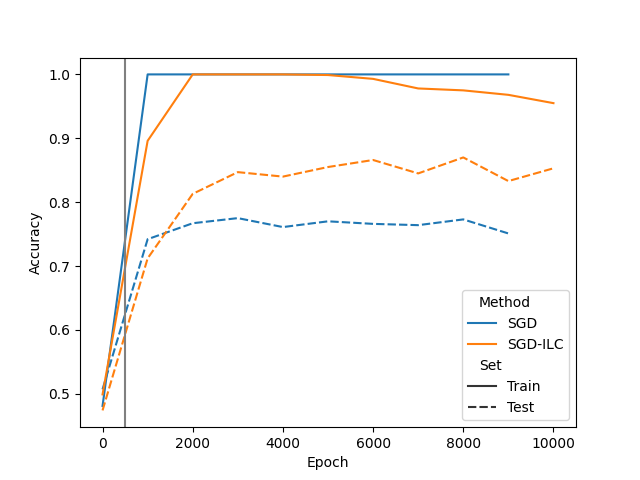

In [124]:
%matplotlib notebook

import pandas as pd
df = pd.DataFrame(results)
df.Accuracy = df.Accuracy.astype('float')
df.Epoch = nepochs*df.Epoch/10

plot_results(df)